# Model inner workings - for methods and supplementary sections

Tormey Reimer  
2 April 2025

# Introduction

In [ ]:
packs <- unique(c('magrittr', 'dplyr', 'tidyr', 'stringr', 'ggplot2', 'here', 'ggpubr', 'patchwork', 'qs', 'arrow', 'targets', 'sf', 'terra', 'rnaturalearth', 'rnaturalearthdata', 'dtplyr', 'furrr', 'RColorBrewer', 'conflicted'))
pacman::p_load(char = packs)

conflicts_prefer(dplyr::select(), dplyr::filter(), .quiet = T)

source(here("src/spatial_templates.R"))
source(here("src/model_functions.R"))

# Sys.setenv(TAR_PROJECT = "project_main")
base_path <- file.path("C:", "Users", "treimer", "Documents", "R-temp-files", "local_to_global_mariculture_modelling")
targets_store <- file.path(base_path, "targets", "_targets_individual")
farm_IDs <- tar_read(farm_IDs, store = targets_store)
b1 <- sample(length(farm_IDs), 100, replace = F)
b2 <- b1 + length(farm_IDs)
b3 <- b2 + length(farm_IDs)
b <- c(b1, b2, b3)

# Temporary questions to answer:

-   Do the fish reach harvest size within a reasonable amount of time?
    -   If not, are they growing for the correct amount of time, starting at the correct weight?
-   Is their FCE/FCR reasonably close to experimental data?
-   Is their SGR reasonably close to experimental data?

# Model approach

We adapted the methods of @baldan_r_2018 to create a bioenergetic model that simulates individual growth and farm-scale production for Atlantic salmon and the resultant nutrient waste in the form of excess labile nitrogen and phosphorus. The model simulates growth at an individual level, calculating the change in individual weight through time using:

$$
\frac{dw}{dt} = \frac{A-C}{\epsilon}
$$

Where $w=$ is wet weight (t), $t=$ time (d), $A=$ anabolic rate (J t$^{-1}$), $C=$ the catabolic rate (J t$^{-1}$), $\epsilon=$ energy density of body tissues (J t$^{-1}$).

Individual models were then upscaled using monte-carlo simulations to simulate size structure in a population. Size differences were achieved through different initial starting weights and ingestion rates for different finfish species. All individuals have a fixed mortality rate to simulate stocking and harvesting.

-   Parameterised for atlantic salmon
-   Farms with mean temperature \< 8.5$^\circ$ were excluded

# Water temp

In [ ]:
# This is the full idealised year (2 years?) of temperature data
sst <- file.path(base_path, "data", "_general_data", "SST", "farm_SST_extracted.parquet") %>% read_parquet()

# This is the actual temperature curve for the farming period
farm_temp <- tar_read(example_individual, store = targets_store, branches = b1)

Originally, all salmon were transferred to grow-out cages (model began) on January 1st. This isn’t particularly realistic. Now, all farms begin the modelling period in spring (1st of May in the northern hemisphere, 1st of October in the southern hemisphere).

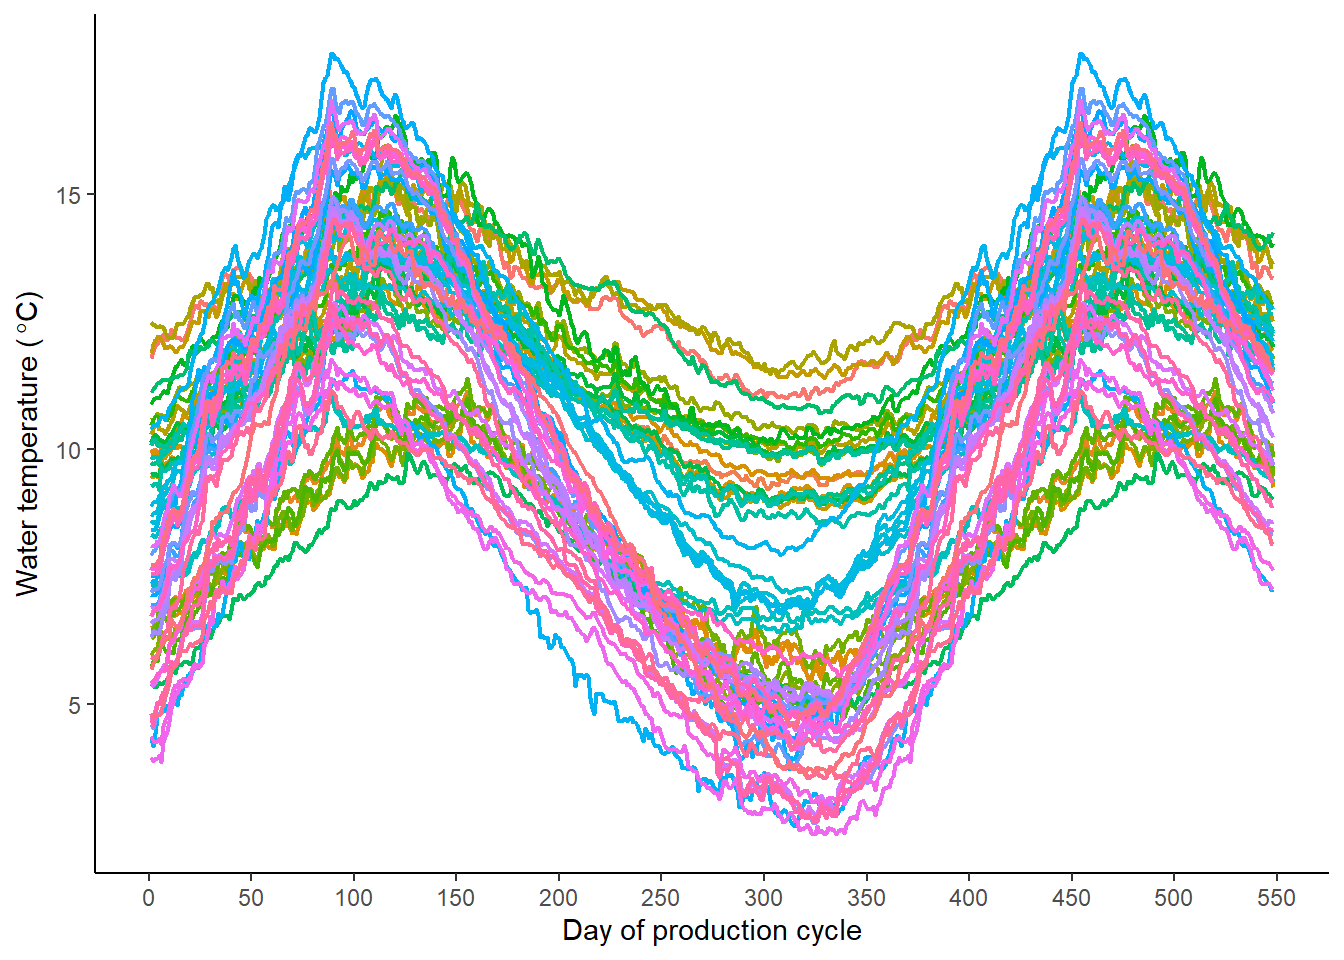

In [ ]:
farm_temp %>% 
  ggplot(aes(x = prod_days, y = water_temp, colour = as.factor(farm_ID))) +
  geom_line(linewidth = 0.75) +
  theme_classic() +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = seq(0, 550, 50)) +
  labs(x = "Day of production cycle", y = expression("Water temperature ("*degree*"C)"))

# Weight

In [ ]:
species_params <- tar_read(species_params, store = targets_store)
pop_params <- tar_read(pop_params, store = targets_store)
weight <- tar_read(example_individual, store = targets_store, branches = b) %>% select(farm_ID, weight, days, prod_days, feed)
SGR <- tar_read(example_individual, store = targets_store, branches = b) %>% select(farm_ID, SGR, days, prod_days, feed)
FCR <- tar_read(example_individual, store = targets_store, branches = b) %>% select(farm_ID, FCR, days, prod_days, feed)

weight_smolt <- weight %>% 
  filter(prod_days == 152 & feed == "reference") %>% 
  group_by(feed) %>% 
  reframe(final_weight = mean(weight))
weight_ocean <- weight %>% 
  filter(prod_days == max(prod_days) & feed == "reference") %>% 
  group_by(feed) %>% 
  reframe(final_weight = mean(weight),
          final_wt_sd = sd(weight))

@fig-ref-weight shows the change in weight for 100 individuals grown at different farms. Within the first 5 months (post-smolt period) the fish grow from 125g to 889.2g, or approximately 7.1$\times$ their starting weight. By the end of the production cycle (730 days) the fish have grown to a mean of 4446.3 g with a SD of 931.1 g. <!-- This is not quite what's needed - I'm expecting individual weights to at least approximate the mean commercial weight of 5kg. -->

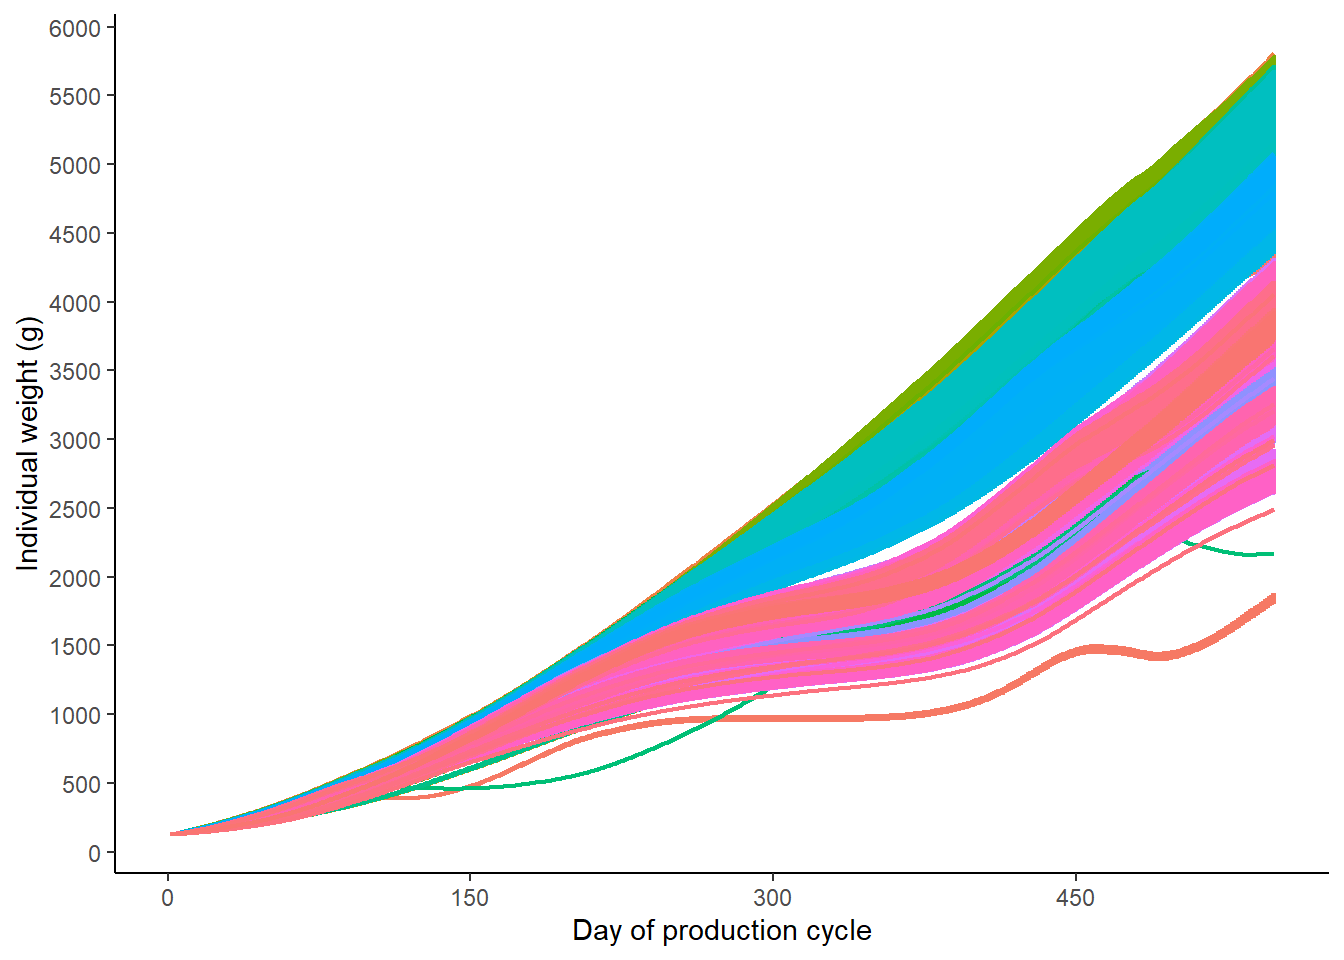

In [ ]:
weight %>% 
  mutate(feed == "reference") %>% 
  ggplot(aes(x = prod_days, y = weight, colour = as.factor(farm_ID))) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(0, 7500, 500)) +
  theme_classic() +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = seq(0, 550, 150)) +
  labs(x = "Day of production cycle", y = "Individual weight (g)")

(`geom_line()`).

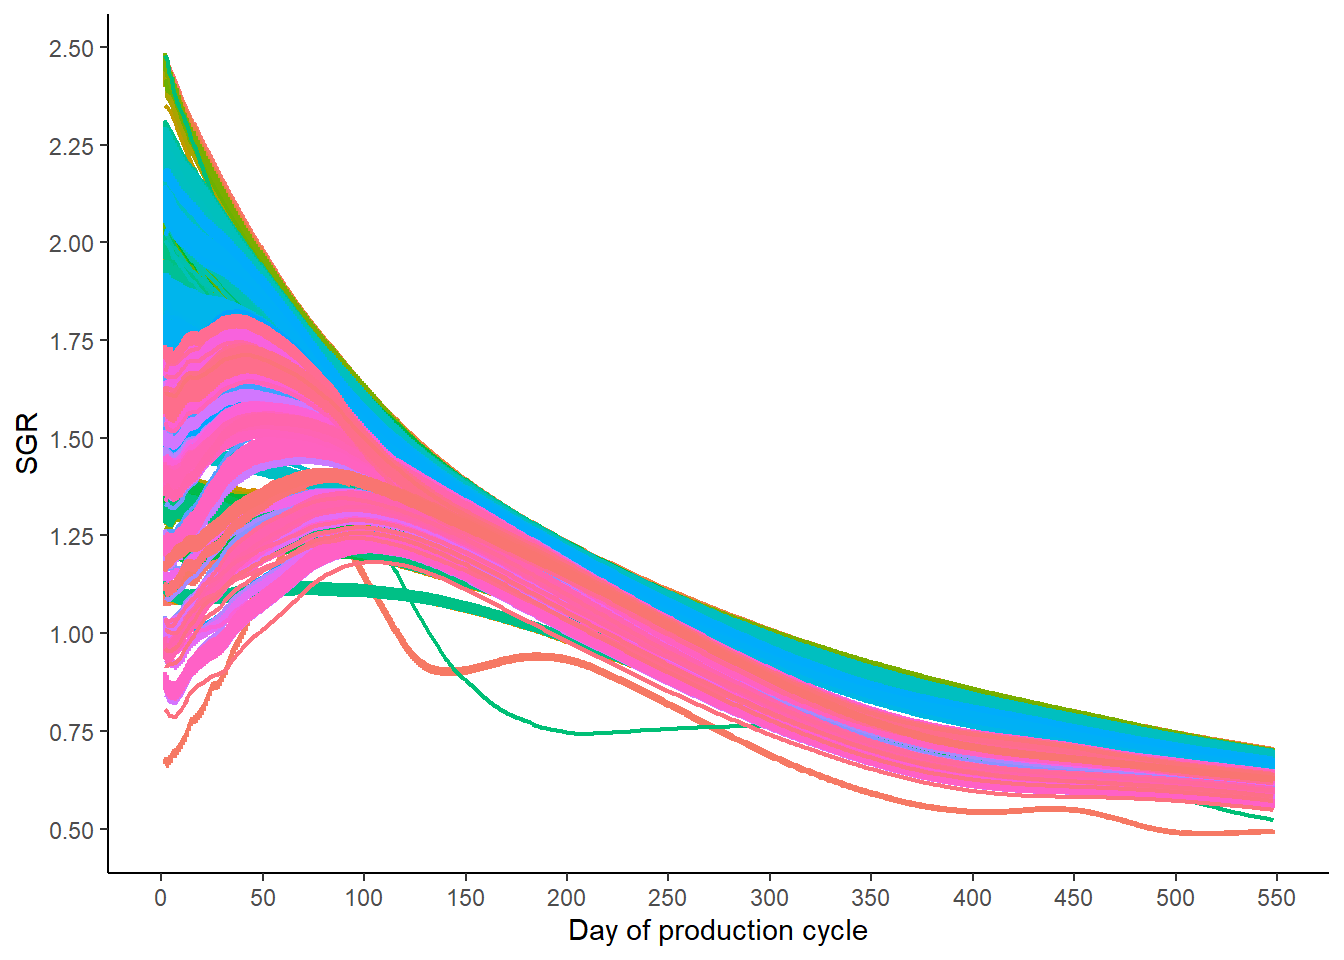

In [ ]:
SGR %>% 
  mutate(feed == "reference") %>% 
  ggplot(aes(x = prod_days, y = SGR, colour = as.factor(farm_ID))) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(0, 2.5, 0.25)) +
  theme_classic() +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = seq(0, 550, 50)) +
  labs(x = "Day of production cycle", y = expression("SGR"))

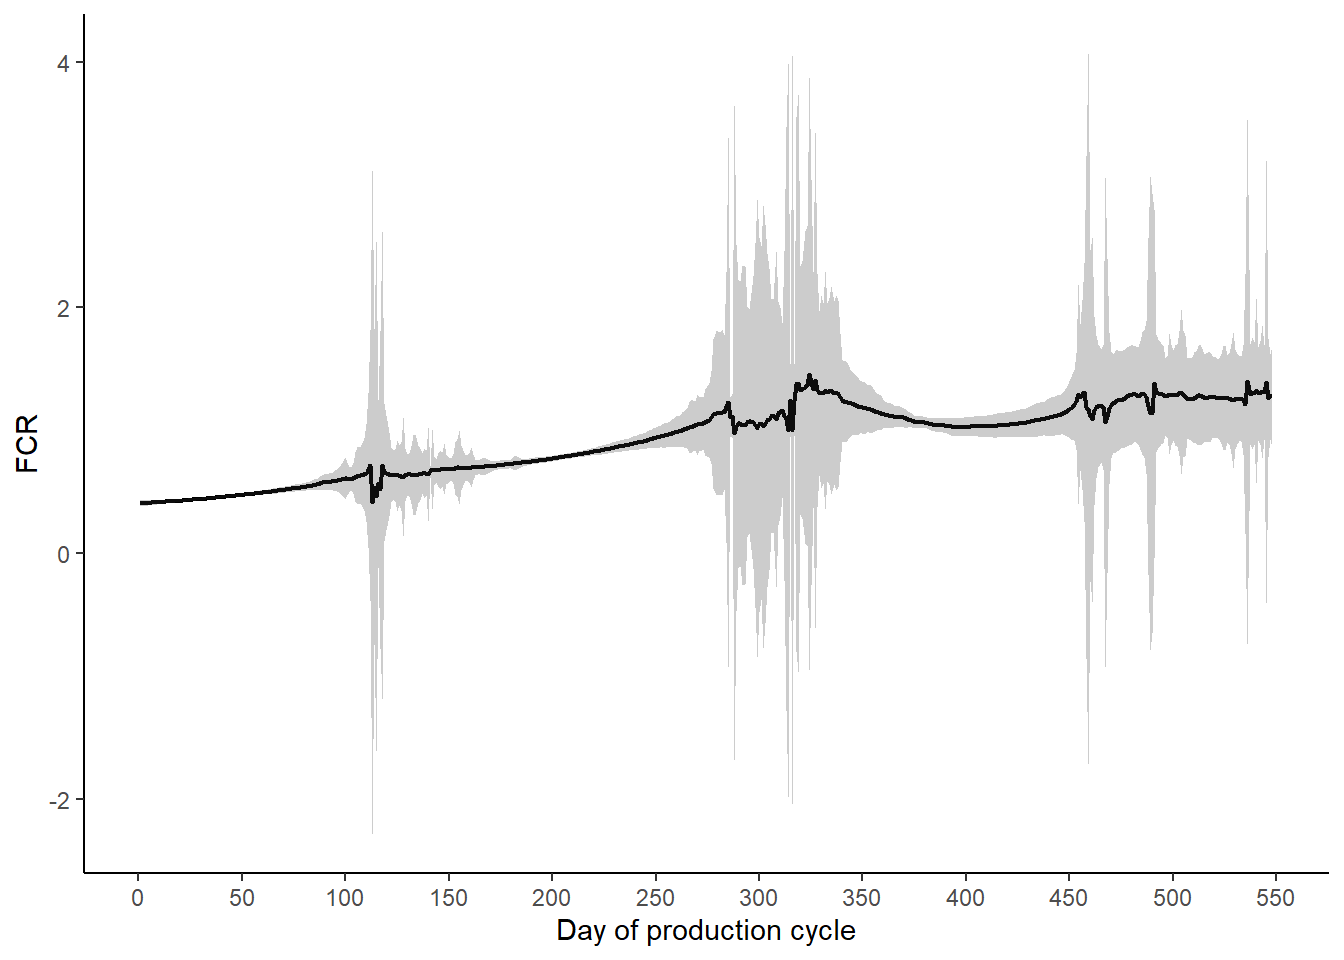

In [ ]:
FCR %>% 
  mutate(feed == "reference") %>% 
  filter(FCR < 50 & FCR > -50) %>% 
  group_by(prod_days) %>% 
  reframe(sd = sd(FCR),
          FCR = mean(FCR)) %>% 
  ggplot(aes(x = prod_days, y = FCR, ymin = FCR-sd, ymax = FCR+sd)) +
  geom_line(linewidth = 0.75) +
  geom_ribbon(alpha = 0.25) +
  theme_classic() +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = seq(0, 550, 50)) +
  labs(x = "Day of production cycle", y = expression("FCR"))

# General fish functions

@fig-functional-response-to-temperature shows the metabolic response of all salmon to temperature (affecting their relative metabolism), and @fig-feeding-rate-with-temperature shows how the salmons’ feeding rate changes with temperature.

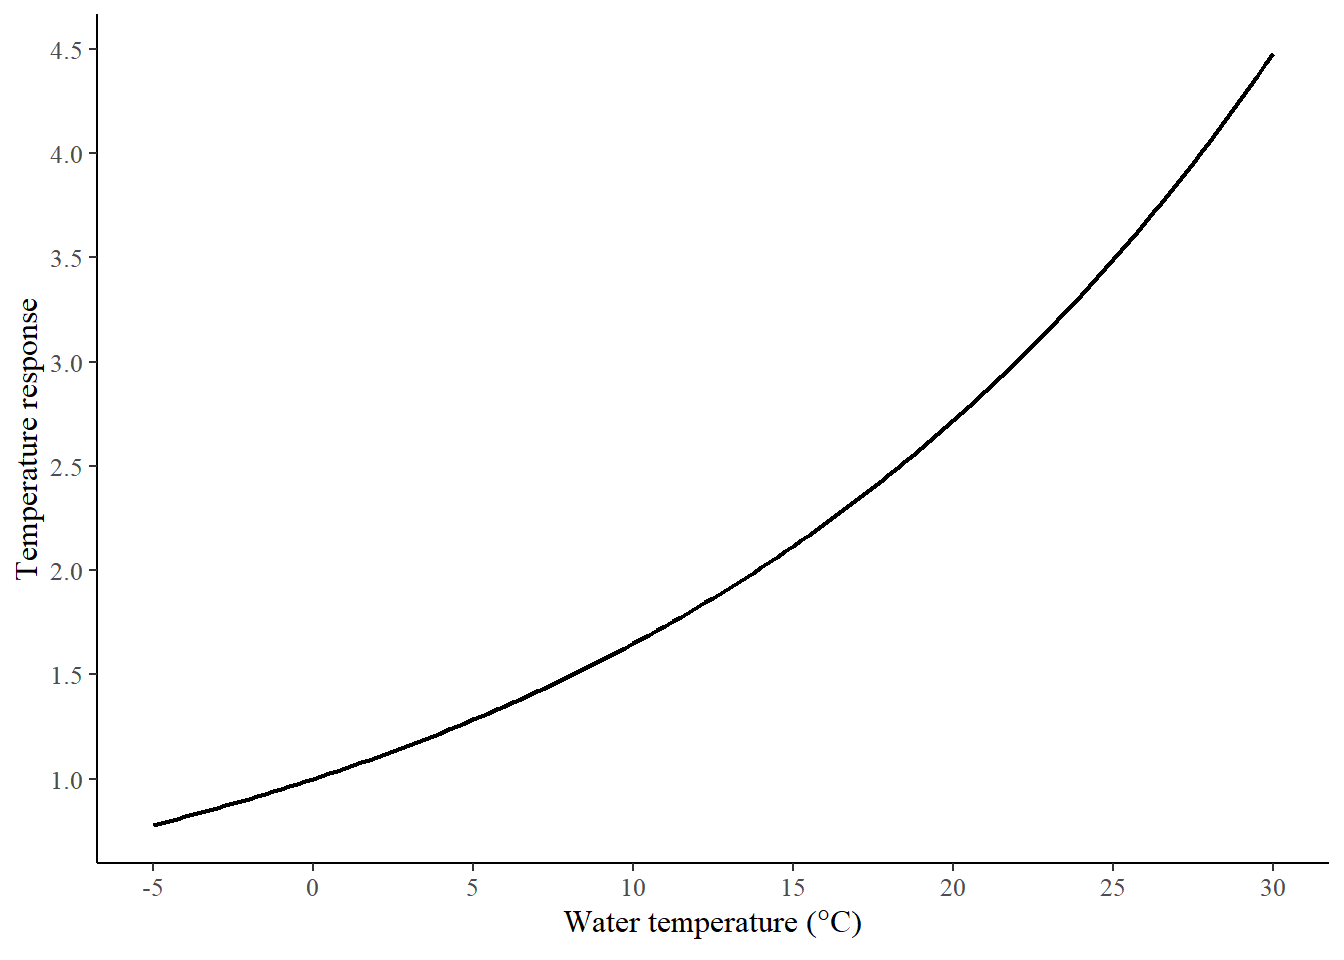

In [ ]:
df <- data.frame(water_temp = seq(-5, 30, 0.25))
df$resp <- exp(species_params['pk']*df$water_temp)

df %>% 
  ggplot(aes(x = water_temp, y = resp)) +
  geom_line(linewidth = 0.75) +
  scale_y_continuous(breaks = seq(0,5,0.5)) +
  scale_x_continuous(breaks = seq(-10,35,5)) +
  labs(x = expression("Water temperature ("*degree*"C)"), y = "Temperature response") +
  theme_classic() +
  theme(text = element_text(colour = "black", family = "serif", size = 12))

$$
cat = \epsilon_{O_2} \times k_0 \times T_{resp} \times W^n \times \omega
$$

Relative feeding rate is temperature-dependent and calculated via:

$$
FR_{rel} = e^{b(T_w-T_{opt})} \times \bigg[\frac{T_{max}-T_w}{T_{max}-T_{opt}}\bigg]^{b(T_{max}-T_{opt})}
$$

where $T_{opt}$ is the optimum feeding temperature, $T_{max}$ is the maximum feeding temperature (lethal temperature), $T_w$ is the current water temperature, and $b$ is a species-specific shape coefficient.

(`geom_line()`).

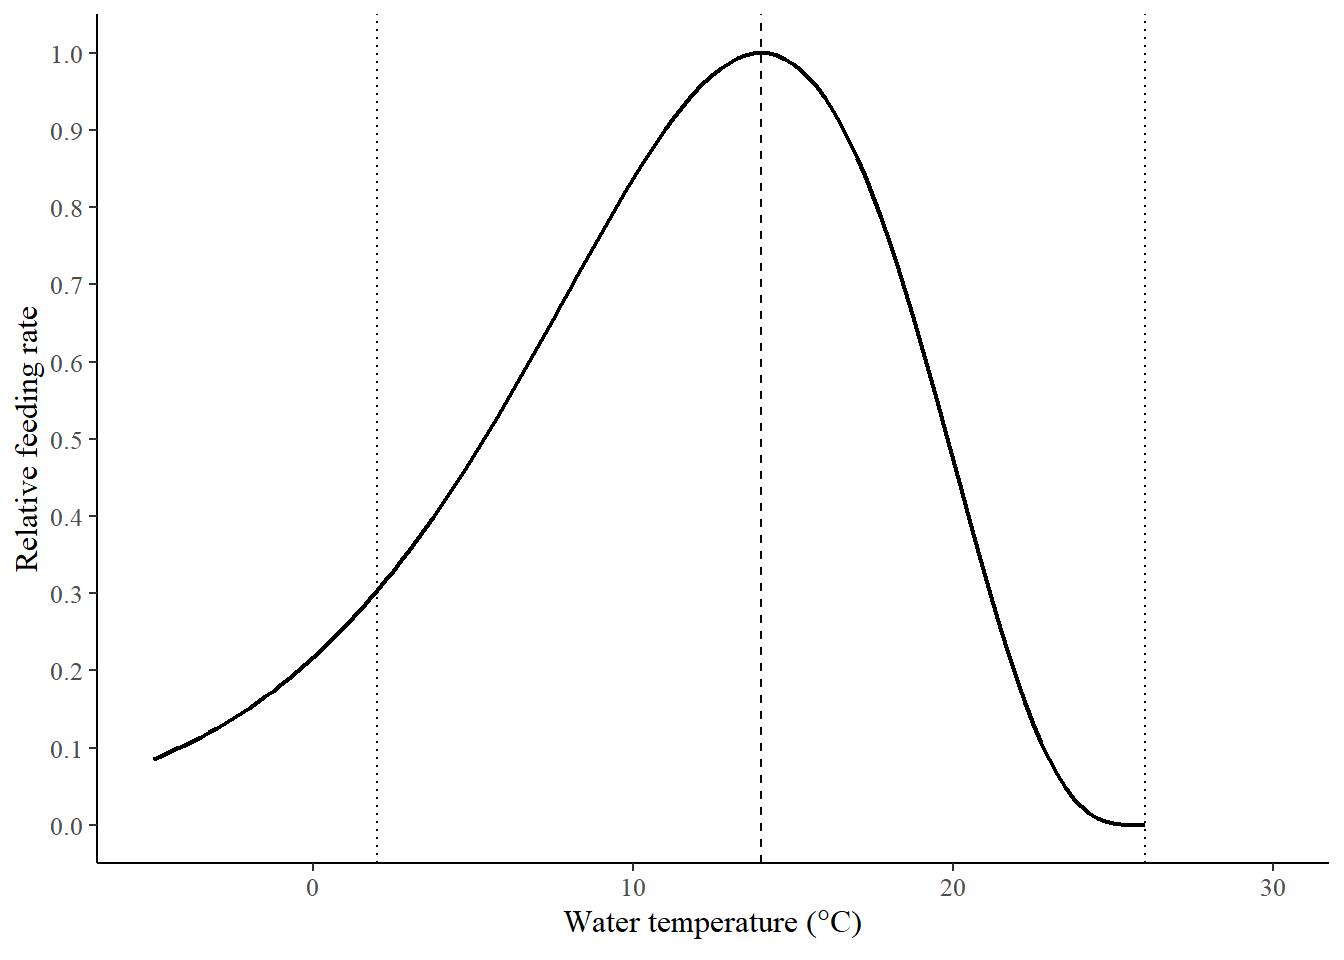

In [ ]:
df <- data.frame(water_temp = seq(-5, 30, 0.25))
df$feeding <- sapply(FUN = feeding_rate, X = df$water_temp, species_params = species_params)

df %>% 
  ggplot(aes(x = water_temp, y = feeding)) +
  geom_line(linewidth = 0.75) +
  geom_vline(aes(xintercept = species_params["Toa"]), linetype = "dashed") +
  geom_vline(aes(xintercept = species_params["Taa"]), linetype = "dotted") +
  geom_vline(aes(xintercept = species_params["Tma"]), linetype = "dotted") +
  scale_y_continuous(breaks = seq(0,1,0.1)) +
  labs(x = expression("Water temperature ("*degree*"C)"), y = "Relative feeding rate") +
  theme_classic() +
  theme(text = element_text(colour = "black", family = "serif", size = 12))

# Feed data

In [ ]:
feed_params_protein <- tar_read(feed_params_protein, store = targets_store)
feed_params_carbs <- tar_read(feed_params_carbs, store = targets_store)
feed_params_lipids <- tar_read(feed_params_lipids, store = targets_store)

Incorporated the individual digestibility of each ingredient and switched to tracking ingredients separately instead of feed – this unfortunately makes the model run slower but I think it will be worth it once the digestibility coefficients from the experiments are incorporated.

In [ ]:
ref_feed <- list(
    feed_params_protein[[1]] %>% 
      mutate(feed = "reference", type = "protein") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest)),
  feed_params_carbs[[1]] %>% 
      mutate(feed = "reference", type = "carb") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest)),
  feed_params_lipids[[1]] %>% 
      mutate(feed = "reference", type = "lipid") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest))
) %>% bind_rows()
past_feed <- list(
    feed_params_protein[[2]] %>% 
      mutate(feed = "past", type = "protein") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest)),
  feed_params_carbs[[2]] %>% 
      mutate(feed = "past", type = "carb") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest)),
  feed_params_lipids[[2]] %>% 
      mutate(feed = "past", type = "lipid") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest))
) %>% bind_rows()
fut_feed <- list(
    feed_params_protein[[3]] %>% 
      mutate(feed = "future", type = "protein") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest)),
  feed_params_carbs[[3]] %>% 
      mutate(feed = "future", type = "carb") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest)),
  feed_params_lipids[[3]] %>% 
      mutate(feed = "future", type = "lipid") %>% group_by(feed, type) %>% 
      reframe(proportion = sum(proportion),
              macro = sum(macro),
              digest = sum(digest))
) %>% bind_rows()

feeds <- rbind(ref_feed, past_feed, fut_feed)

# Individual runs

I set up some “example fish” to speed up future model adjustments – basically fish that are the average of their whole farm, easier than running 5000 fish per farm while I’m making changes.

## Food provided vs food eaten

In [ ]:
#c(b1, b2, b3))
ing_pot <- tar_read(example_individual, store = targets_store, branches = b1) %>% select(farm_ID, ing_pot, days, prod_days, feed)
ing_act <- tar_read(example_individual, store = targets_store, branches = b1) %>% select(farm_ID, ing_act, days, prod_days, feed)
food_prov <- tar_read(example_individual, store = targets_store, branches = b1) %>% select(farm_ID, food_prov, days, prod_days, feed)

Within the model, salmon have a maximum ingestion potential (based on their weight and individualised feeding rate). The actual food ingested is 97% of their ingestion potential (food encounter efficiency) or the total food provided, whichever is less. @fig-food-prov-theoretical shows an example of how food provided scales with potential individual ingestion.

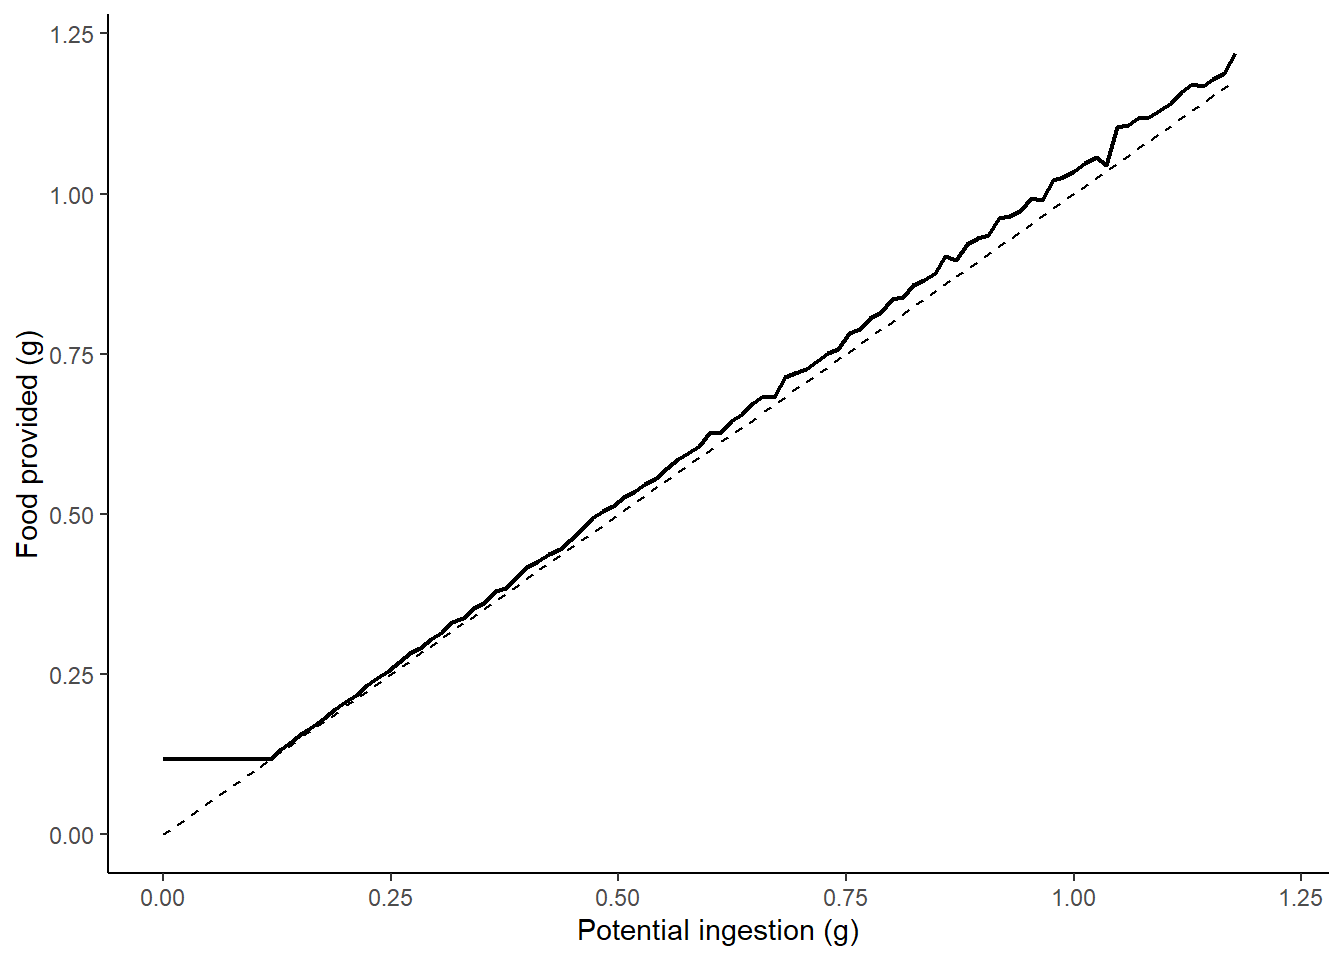

In [ ]:
df <- data.frame(rel_feeding = seq(0,1,0.01)) %>% 
mutate(ing_pot = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * rel_feeding,
       food_prov = NA)
for (i in 1:nrow(df)) {
  df$food_prov[i] <- food_prov_rate(rel_feeding = df$rel_feeding[i], ing_pot = df$ing_pot[i], 
                                    ing_pot_10 = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * 0.1)
}
lin <- seq(0,max(df$ing_pot),length.out=101)

df %>% 
  ggplot(aes(x = ing_pot, y = food_prov)) +
  geom_line(linewidth = 0.75) +
  geom_line(aes(x = lin, y = lin), linetype = "dashed") +
  theme_classic() +
  scale_x_continuous(breaks = seq(0,1.5, 0.25), limits = c(0,max(df$food_prov))) +
  scale_y_continuous(breaks = seq(0,1.5, 0.25)) +
  labs(x = "Potential ingestion (g)", y = "Food provided (g)")

In [ ]:
prov <- merge(ing_pot, ing_act, by = c("farm_ID", "feed", "days", "prod_days")) %>% 
  merge(food_prov, by = c("farm_ID", "feed", "days", "prod_days")) %>% 
  mutate(uneaten = food_prov - ing_act,
         uneaten_perc = uneaten/food_prov) %>% 
  select(-c(food_prov, ing_act))

# Therefore, uneaten feed can be quite high (up to \~30%) when relative feeding is $\leq$10%. But generally, the median amount of uneaten food is `r round(100*median(prov$uneaten_perc), 1)`% (@fig-uneaten-feed).

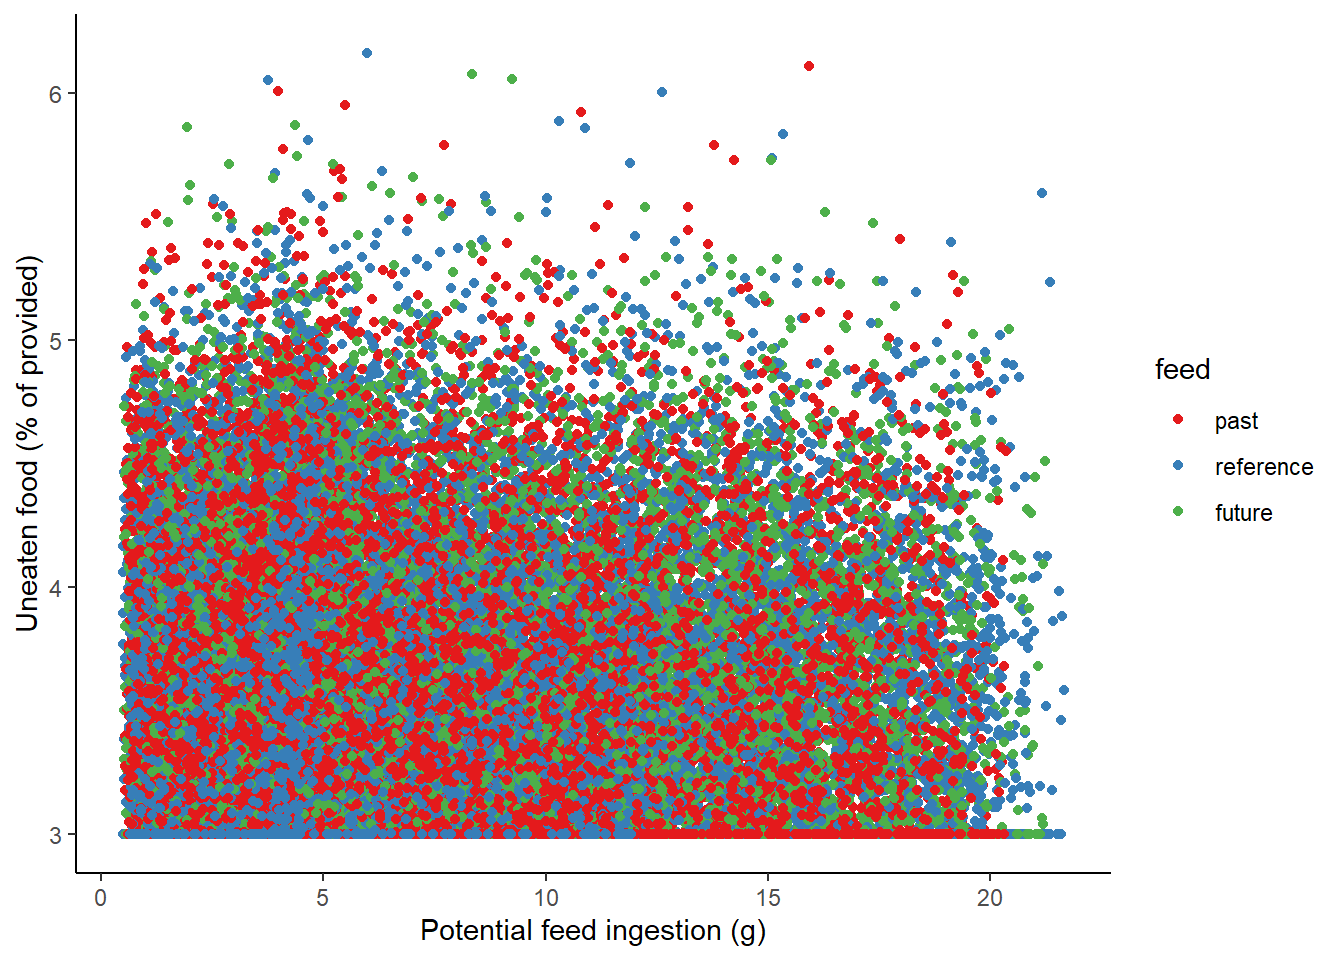

In [ ]:
prov %>% 
  ggplot(aes(x = ing_pot, y = 100*uneaten_perc, colour = feed)) +
  geom_point() +
  theme_classic() +
  scale_colour_brewer(palette = "Set1") +
  theme_classic() +
  labs(x = "Potential feed ingestion (g)", y = "Uneaten food (% of provided)")

# Parameters for Atlantic salmon

In [ ]:
params <- tar_read(sens_all_params, store = targets_store)
pnames <- names(params)

| Parameter | Value | Units | Description | Reference | Comment |
|:--:|:--:|:--:|----|----|----|
| $\alpha$ | 0.04 | \- | Feeding catabolism coefficient | @broekhuizen_modelling_1994 | *Salvelinus alpinus*, *Oncorhynchus mykiss* (temps: 8–13$^{\circ}$C) |
| $\epsilon_{P}$ | 2.36^{4} | J g protein-1 | Energy content of protein | @baldan_r_2018 |  |
| $\epsilon_{L}$ | 3.62^{4} | J g lipid-1 | Energy content of lipid | @baldan_r_2018 |  |
| $\epsilon_{C}$ | 1.72^{4} | J g carbohydrate-1 | Energy content of carbohydrate | @baldan_r_2018 |  |
| $\epsilon_{O_2}$ | 1.34^{4} | J g O2-1 | Energy consumed by the respiration of 1 g of oxygen | @elliott_energy_1975 |  |
| $pk$ | 0.05 | d-1 | Temperature coefficient for the fasting catabolism | @macnaughton_using_2019 |  |
| $k_0$ | 0.003 | degree C-1 | Fasting catabolism at 0 Celsius degree | @macnaughton_using_2019 |  |
| $m$ | 0.75 | \- | Weight exponent for the anabolism | @broekhuizen_modelling_1994 | *Salmo trutta* (temps: 8–13$^{\circ}$C) |
| $n$ | 1 | \- | Weight exponent for the catabolism | @baldan_r_2018 |  |
| $\beta C$ | 0.3234 | \- | Shape coefficient for the feeding function | @jonsson_thermal_2001 | Fish size range: 2.25\$$0.49 – 11.5$$5.29 g, temperature ranges: 5–24$^{}\$C. Coefficent for mean daily energy intake of the moderately fast growing group, 0.4398 (mean fast group), 0.2214 (mean slow group) |
| $T_{max}$ | 26 | C | Maximum lethal temperature | @poletto_unusual_2017 | Juvenile Chinook salmon (19.8\$$0.02 g, acclimation temp: 15$<sup>{</sup>}$C, 19${}\$C) |
| $T_{opt}$ | 18 | C | Optimal temperature | @jonsson_thermal_2001 | Fish size range: 2.25\$$0.49 – 11.5$$5.29 g, temperature ranges: 5–24$<sup>{</sup>}$C.
Alt value: 14°C [@handeland_effect_2008], *Salmo salar* initial size: 77.0$$14.6 g, temps: 6, 10, 14, 18${}\$C |
| $T_{min}$ | 2 | C | Lowest feeding temperature | @vadboncoeur_lowering_2023 | Fish essentially stop feeding when below 2$^{\circ}$C |
| $a$ | 2669 | J g tissue-1 | Energy content of fish tissue | @van_tien_development_2016 | Alt value: 17.02350 (nls model fitted to female Atlantic salmon data extracted and transformed from @jonsson_energy_2003 |
| $k$ | 0.1715 | \- | Weight exponent for energy content | @van_tien_development_2016 | Alt value: 1.65175 (nls model fitted to female Atlantic salmon data extracted and transformed from @jonsson_energy_2003 |
| $eff$ | 0.97 | \- | Food ingestion efficiency | @uglem_does_2020 | Range: 95-97% ingestion efficiency |
| $\overline{W}$ | 175 | g | Dry weight mean | @dempsey_estimating_2023 | Range of 100-150 given so used a mean of 125 and sd of 10 which over 1000 draws from a normal distribution delivers a minimum and maximum close to these numbers |
| $\Delta{W}$ | NA | g | Dry weight standard deviation | @dempsey_estimating_2023 | Range of 100-150 given so used a mean of 125 and sd of 10 which over 1000 draws from a normal distribution delivers a minimum and maximum close to these numbers |
| $Wlb$ | NA | g | Dry weight lower bound | Reference |  |
| $\overline{I_{max}}$ | 0.035 | g g-1 fish day-1 | Ingestion rate mean | [FAO](https://www.fao.org/fileadmin/user_upload/affris/docs/tabl10.pdf) |  |
| $\Delta{I_{max}}$ | NA | g g-1 fish day-1 | Ingestion rate standard deviation | [FAO](https://www.fao.org/fileadmin/user_upload/affris/docs/tabl10.pdf) |  |
| $mort$ | NA | d-1 | Natural mortality rate | @tvete_towards_2023 |  |

Params

## Sensitivity

In the following plots, a value \> 0 indicates that increasing that parameter increases the output variable while a negative value indicates that increasing the parameter decreases the variable. The sensitivity follows a power relationship, such that output$_1$ $\propto$ output$_0^{S}$.

In [ ]:
sens_wt <- file.path("..", "data", "atlantic_salmon", "data_products", "weight_parameter_sensitivity.parquet") %>% 
  read_parquet() %>% 
  mutate(adj_param = factor(adj_param, levels = rev(adj_param)))
# sens_dw <- file.path("data", "atlantic_salmon", "data_products", "dw_parameter_sensitivity.parquet") %>% 
#   read_parquet() %>% 
#   mutate(adj_param = factor(adj_param, levels = rev(adj_param)))
# sens_excr <- file.path("data", "atlantic_salmon", "data_products", "excreted_parameter_sensitivity.parquet") %>% 
#   read_parquet() %>% 
#   mutate(adj_param = factor(adj_param, levels = rev(adj_param)))
# sens_uneat <- file.path("data", "atlantic_salmon", "data_products", "uneaten_parameter_sensitivity.parquet") %>% 
#   read_parquet() %>% 
#   mutate(adj_param = factor(adj_param, levels = rev(adj_param)))

Looking at @fig-param-sens-weight:

-   The most sensitive parameter by far is $m$ the weight exponent for anabolism, followed closely by $n$ the weight exponent for catabolism
-   These two are also relatively uncertain, as $m$ was taken from *Salmo trutta* measurements in a fairly old paper \[@broekhuizen_modelling_1994\] and $n$ was taken from @baldan_r_2018 which did not specifically look at Atlantic salmon. There must be more up-to-date measurements for Atlantic salmon in particular.

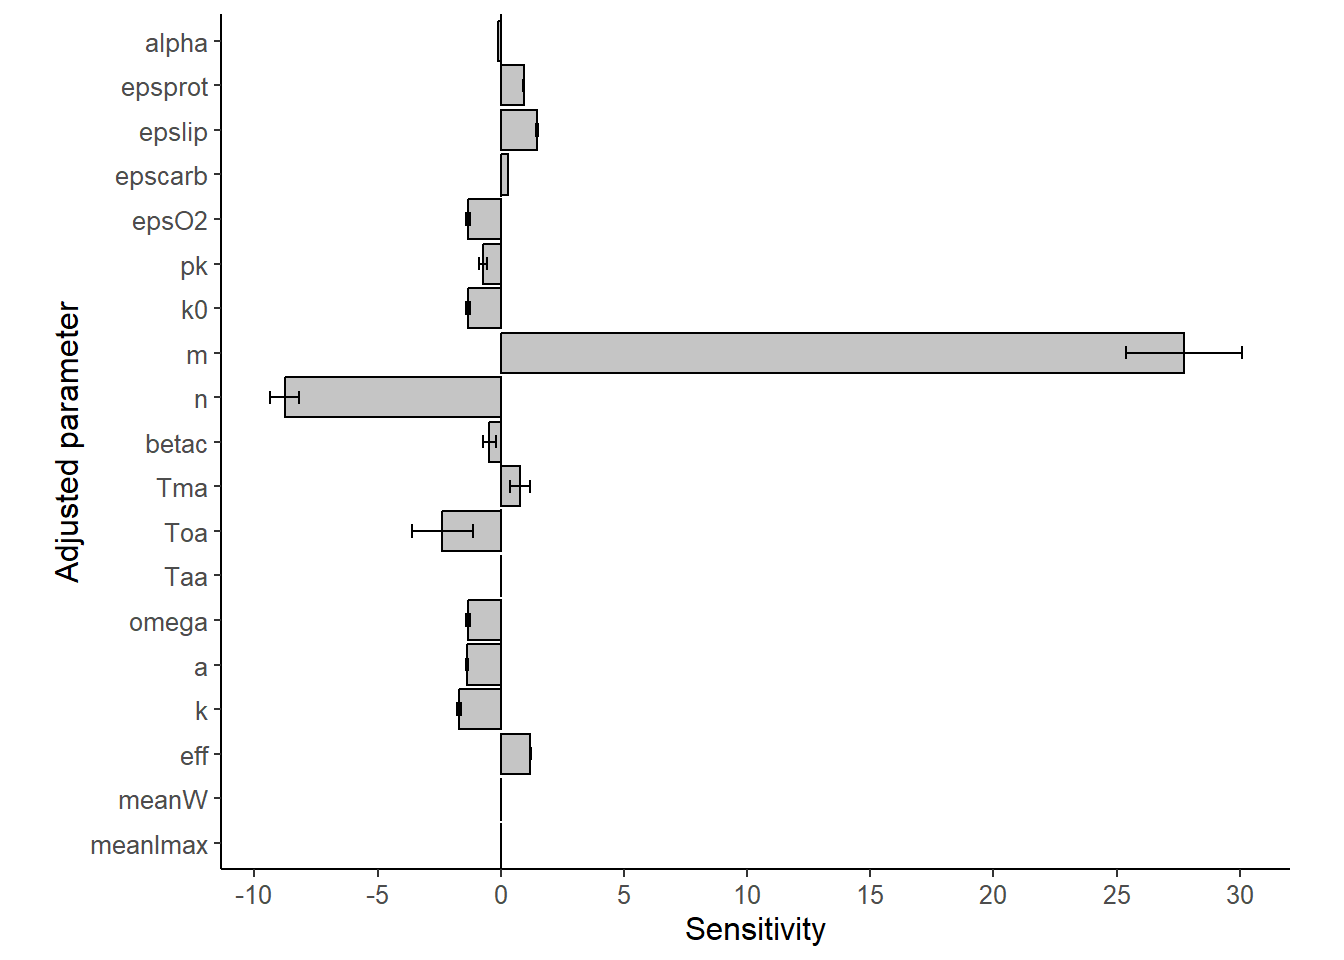

In [ ]:
(
  p_sens <- sens_wt %>% 
    ggplot(aes(x = adj_param, y = sens, ymin = sens-sd, ymax = sens+sd)) +
    geom_col(alpha = 0.35, colour = "black") +
    geom_errorbar(width = 0.3) +
    geom_hline(aes(yintercept = 0), linetype = "dashed") +
    scale_y_continuous(breaks = seq(-20,30,5)) +
    labs(x = "Adjusted parameter", y = "Sensitivity") +
    theme_classic() + theme(legend.position = "none", 
          strip.text = element_blank(), 
          aspect.ratio = 0.8,
          text = element_text(size = 12)) +
    coord_flip()
 )

In [ ]:
p_sens %+% sens_dw

In [ ]:
p_sens %+% sens_excr

In [ ]:
p_sens %+% sens_uneat

# References